In [ ]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import SimpleITK as sitk
from radiomics import featureextractor
import logging
import matplotlib
import matplotlib.colors as mcolors
import scipy.ndimage as ndi
import tqdm


In [3]:
# Set log level for radiomics to suppress warnings
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)

In [4]:
brats_dir = "./BraTS2020" 
path_train = os.path.join(brats_dir, "BraTS2020_TrainingData", "MICCAI_BraTS2020_TrainingData")
map_train = pd.read_csv(os.path.join(path_train, "name_mapping.csv"))
surviv_train = pd.read_csv(os.path.join(path_train, "survival_info.csv"))

BraTScode/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv

In [5]:
## edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core(blue)

SEGMENT_CLASSES = {
    0: 'non-enhancing solid core',
    1: 'necrotic/cystic core',
    2: 'edema',
    4: 'enhancing core'
}

In [ ]:
def create_expanded_mask_multilabel(segmentation, expansion_size=3):
    """Creates an expanded segmentation mask, expanding each label separately.

    Args:
        segmentation (sitk.Image): The original segmentation mask.
        expansion_size (int): The number of voxels to expand each mask in each direction.

    Returns:
        sitk.Image: The expanded segmentation mask, or the original if an error occurs.
    """
    try:
        segmentation_array = sitk.GetArrayFromImage(segmentation)
        expanded_segmentation_array = np.copy(segmentation_array) #initialize with original segmentation

        for label in [4, 2, 1]:  # Iterate through tumor labels
            mask = segmentation_array == label  # Create binary mask for the current label
            if np.any(mask): #check if there are any voxels with this label
                expanded_mask = ndi.binary_dilation(mask, iterations=expansion_size).astype(int)
                # Correct assignment: Only assign to background (0) areas
                expanded_segmentation_array[np.logical_and(expanded_mask, expanded_segmentation_array == 0)] = label
            else:
                print(f"No voxels found with label {label}")

        expanded_segmentation = sitk.GetImageFromArray(expanded_segmentation_array)
        expanded_segmentation.CopyInformation(segmentation)
        return expanded_segmentation

    except Exception as e:
        print(f"Error creating expanded mask: {e}")
        return segmentation

In [ ]:
def extract_features(case_dir, output_csv_original, output_csv_perturbed):
    extractor = featureextractor.RadiomicsFeatureExtractor()
    features_list_original = []
    features_list_perturbed = []

    

    for root, _, files in tqdm.tqdm(os.walk(case_dir), desc="Extracting features", total=len(map_train), unit="files"):
        # Check if segmentation file exists in this directory
        seg_files = [f for f in files if f.endswith("seg.nii")]
        if not seg_files:
            continue  # Skip if no segmentation file

        # Extract case name from the segmentation file
        for seg_file in seg_files:
            case_name = "_".join(seg_file.split("_")[:3])  # Extract case name prefix
            seg_file_path = os.path.join(root, seg_file)

            # Find all modality files
            modalities = {}
            for modality in ['t1', 't1ce', 't2', 'flair']:
                modality_file = f"{case_name}_{modality}.nii"
                modality_path = os.path.join(root, modality_file)
                if os.path.exists(modality_path):
                    modalities[modality] = modality_path

            # Verify all required modalities are present
            if len(modalities) != 4:
                print(f"Skipping {case_name} due to missing modalities")
                continue

            # Load segmentation mask
            segmentation = sitk.ReadImage(seg_file_path)

            # Extract features for each modality
            for modality, img_path in modalities.items():
                #print(f"Extracting features for {case_name} - {modality}")
                image = sitk.ReadImage(img_path)

                try:
                    # Original Mask Feature Extraction
                    features_original = extractor.execute(image, segmentation)
                    features_dict_original = {'case': case_name, 'modality': modality, 'mask_type': 'original'}
                    features_dict_original.update({k: v for k, v in features_original.items() if k.startswith("original")})
                    features_list_original.append(features_dict_original)

                    # Create and apply perturbed mask
                    perturbed_segmentation = create_expanded_mask_multilabel(segmentation, expansion_size=3) # 3 voxel expansion
                    if perturbed_segmentation is not None:
                         
                        # Save perturbed mask
                        filename = f"{case_name}_seg_perturbed_multi.nii"
                        sitk.WriteImage(perturbed_segmentation, os.path.join(root, filename))
                        try:
                            features_perturbed = extractor.execute(image, perturbed_segmentation)
                            features_dict_perturbed = {'case': case_name, 'modality': modality, 'mask_type': 'perturbed'}
                            features_dict_perturbed.update({k: v for k, v in features_perturbed.items() if k.startswith("original")})
                            features_list_perturbed.append(features_dict_perturbed)
                        except Exception as e:
                            print(f"Radiomics Feature Extraction Error for {case_name} - {modality}: {e}")
                            continue # go to the next modality
                    else:
                      print(f"Perturbed mask creation failed for {case_name} - {modality}")
                      continue # go to the next modality

                except Exception as e:
                    print(f"Failed to extract features for {case_name} - {modality}: {e}")
                    continue # go to the next modality


    # Convert to DataFrame and save to CSV
    df_original = pd.DataFrame(features_list_original)
    df_original.to_csv(output_csv_original, index=False)
    print(f"Original features saved to {output_csv_original}")

    df_perturbed = pd.DataFrame(features_list_perturbed)
    df_perturbed.to_csv(output_csv_perturbed, index=False)
    print(f"Perturbed features saved to {output_csv_perturbed}")

In [29]:
def plot_segmentations(patient_id, path):
    patient_path = os.path.join(path, patient_id)
    seg = nib.load(os.path.join(patient_path, f"{patient_id}_seg.nii")).get_fdata()
    perturbed = nib.load(os.path.join(patient_path, f"{patient_id}_seg_perturbed_multi.nii")).get_fdata()

    fig, ax = plt.subplots(1, 2, figsize=(10, 7))

    # Plot segmentation with correct colormap and labels
    #cmap = plt.cm.get_cmap("viridis", len(SEGMENT_CLASSES))  # Use a discrete colormap
    colors = ["black", "green", "yellow", "black", "red"]
    cmap = mcolors.ListedColormap(colors)
    im = ax[0].imshow(seg[..., 80], cmap=cmap, vmin=0, vmax=max(SEGMENT_CLASSES.keys())) #set vmin and vmax
    im = ax[1].imshow(perturbed[..., 80], cmap=cmap, vmin=0, vmax=max(SEGMENT_CLASSES.keys())) #set vmin and vmax

    # create patches and get the colors from the colormap
    patches = [matplotlib.patches.Patch(color=cmap(i), label=SEGMENT_CLASSES[i]) for i in SEGMENT_CLASSES if i in np.unique(seg)]
    # Add legend for segmentation labels
    ax[0].set_title("Segmentation")
    ax[0].legend(handles=patches, title="Segmentation", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

    #ax[1].imshow(perturbed[..., 80], cmap="gray")
    ax[1].set_title("Perturbed Segmentation")

    plt.tight_layout() #prevents labels from overlapping
    plt.show()


In [53]:
# Create list of patient ids to plot: 
patient_ids = map_train["BraTS_2020_subject_ID"].tolist()
patient_ids = patient_ids[:30] + patient_ids[270:300] # Plot some HGG and LGG patients

Patient ID: BraTS20_Training_002
Grade: HGG


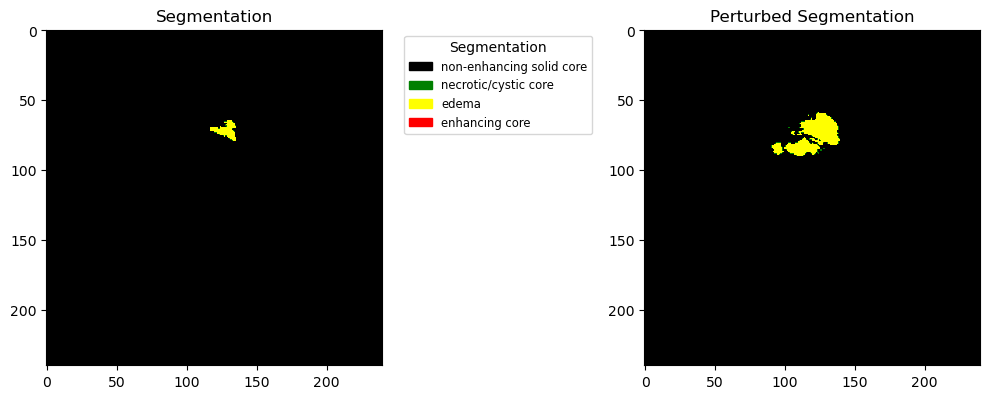

Patient ID: BraTS20_Training_003
Grade: HGG


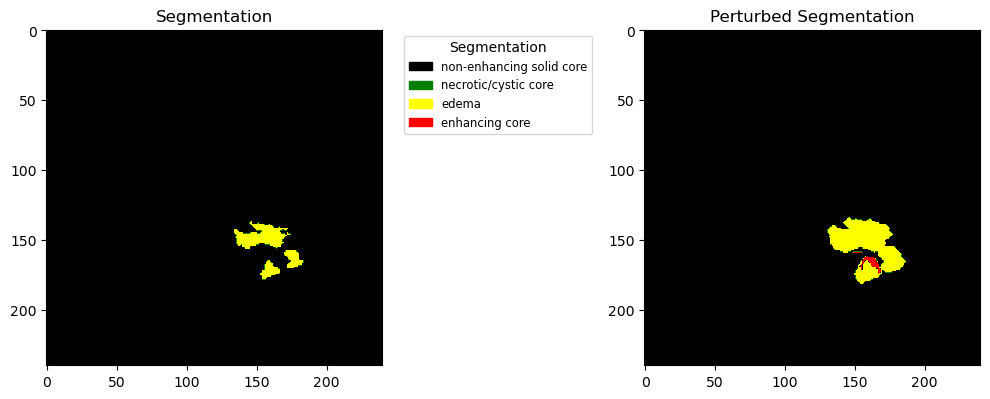

Patient ID: BraTS20_Training_004
Grade: HGG


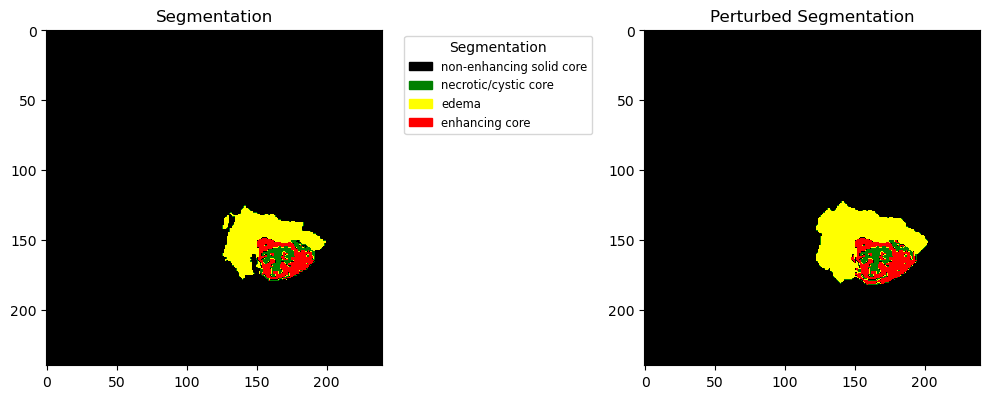

Patient ID: BraTS20_Training_005
Grade: HGG


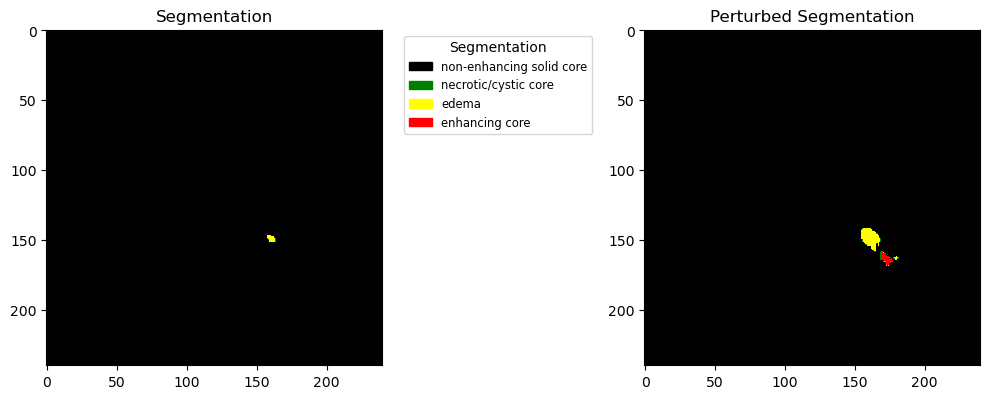

Patient ID: BraTS20_Training_006
Grade: HGG


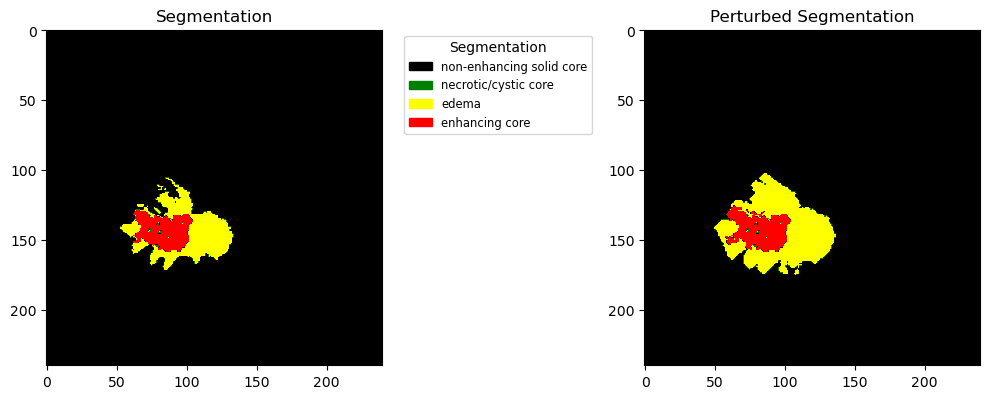

Patient ID: BraTS20_Training_007
Grade: HGG


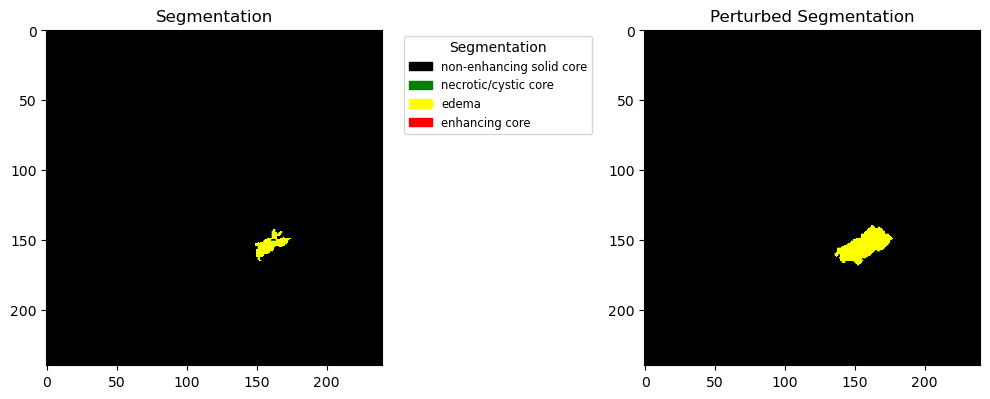

Patient ID: BraTS20_Training_008
Grade: HGG


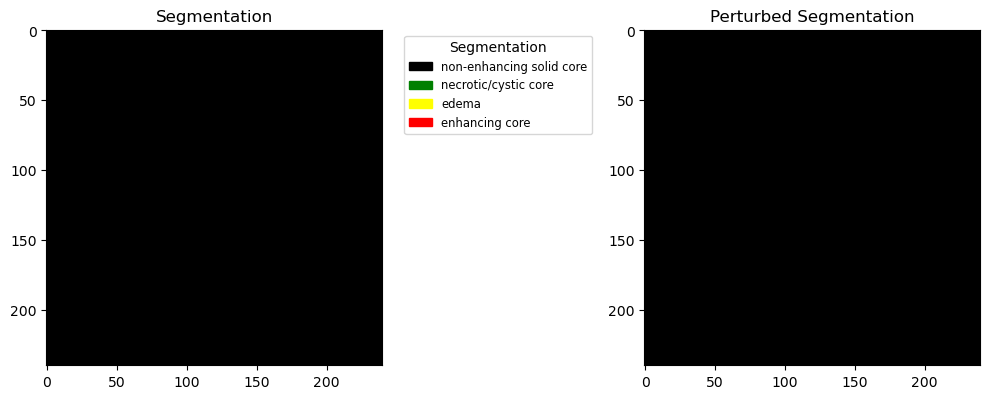

Patient ID: BraTS20_Training_009
Grade: HGG


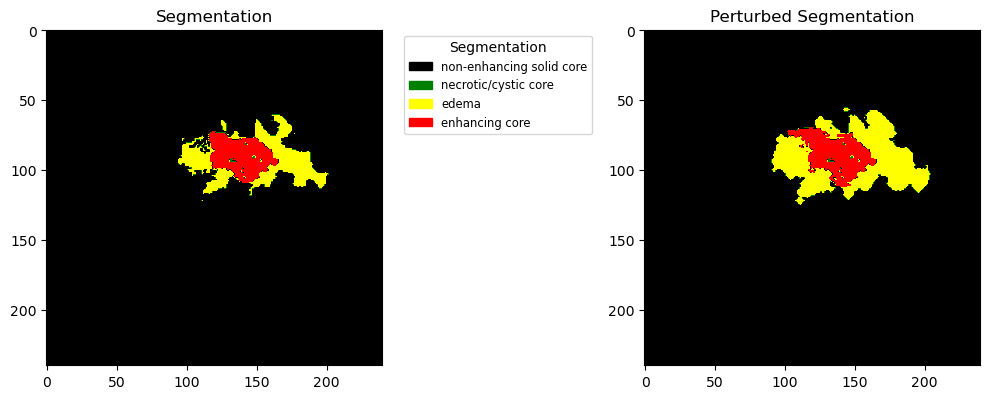

Patient ID: BraTS20_Training_010
Grade: HGG


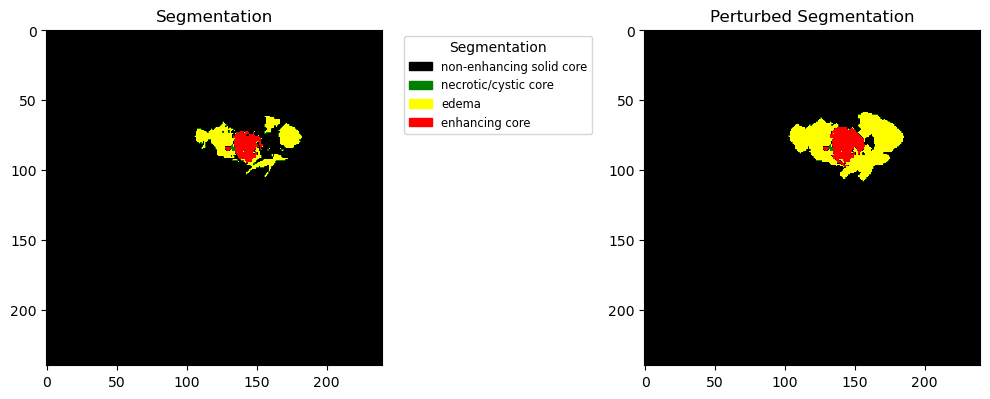

Patient ID: BraTS20_Training_011
Grade: HGG


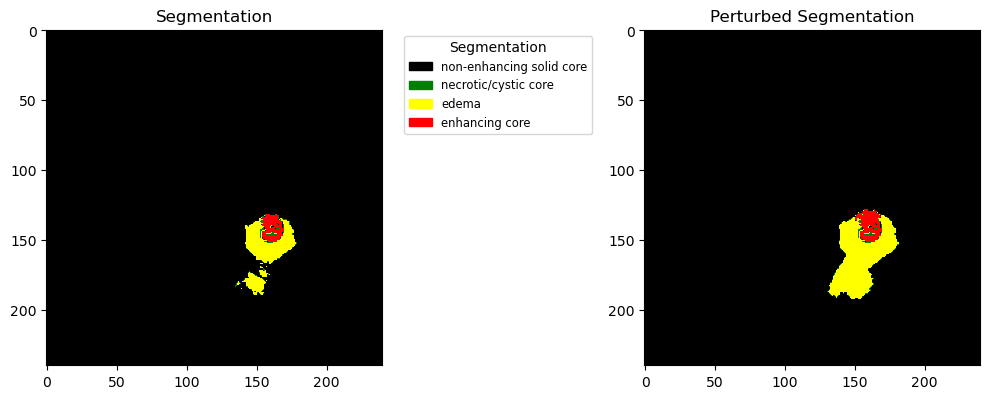

Patient ID: BraTS20_Training_012
Grade: HGG


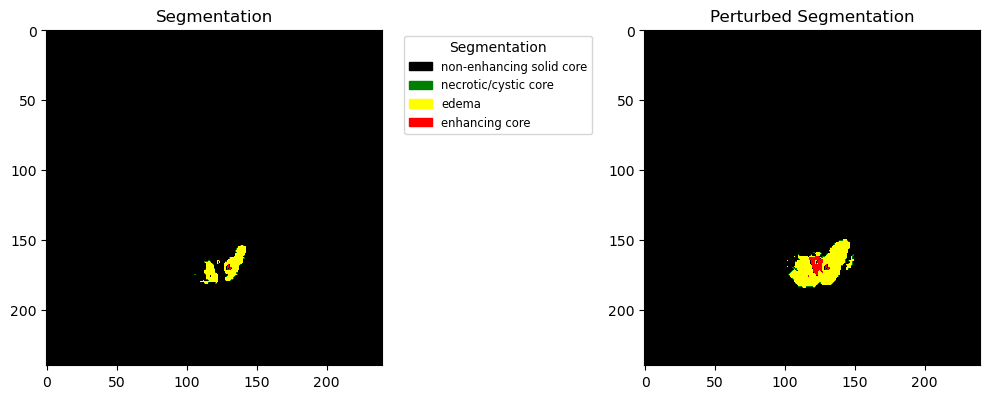

Patient ID: BraTS20_Training_013
Grade: HGG


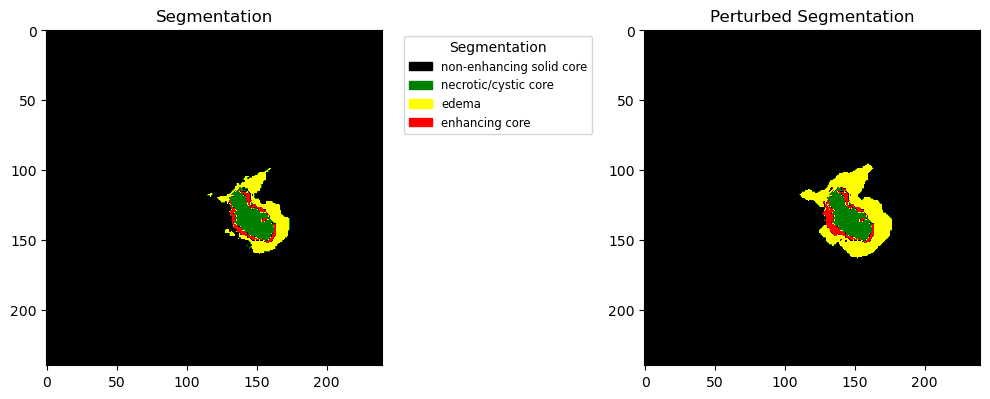

Patient ID: BraTS20_Training_014
Grade: HGG


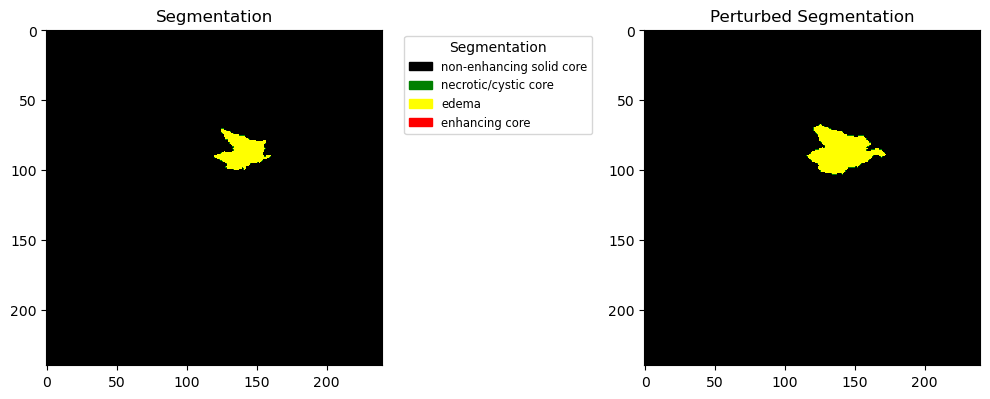

Patient ID: BraTS20_Training_015
Grade: HGG


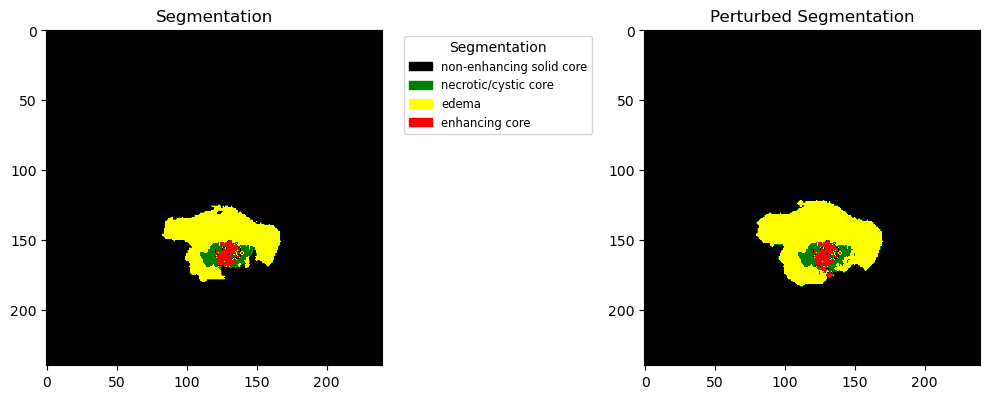

Patient ID: BraTS20_Training_016
Grade: HGG


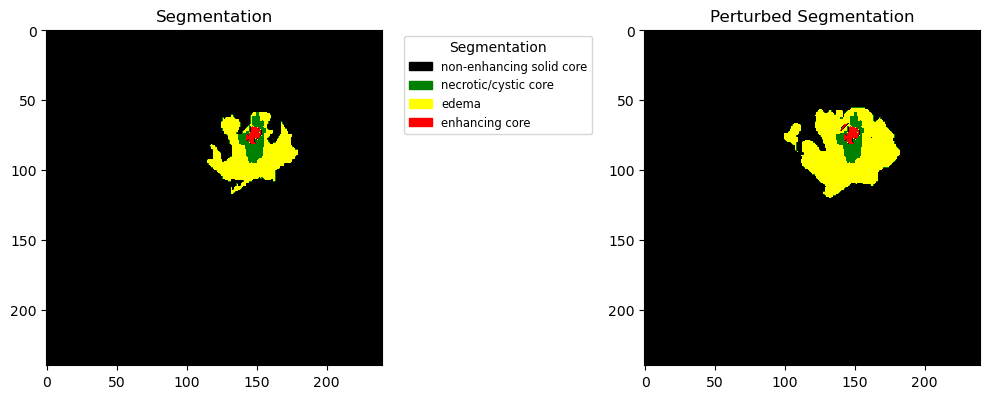

Patient ID: BraTS20_Training_017
Grade: HGG


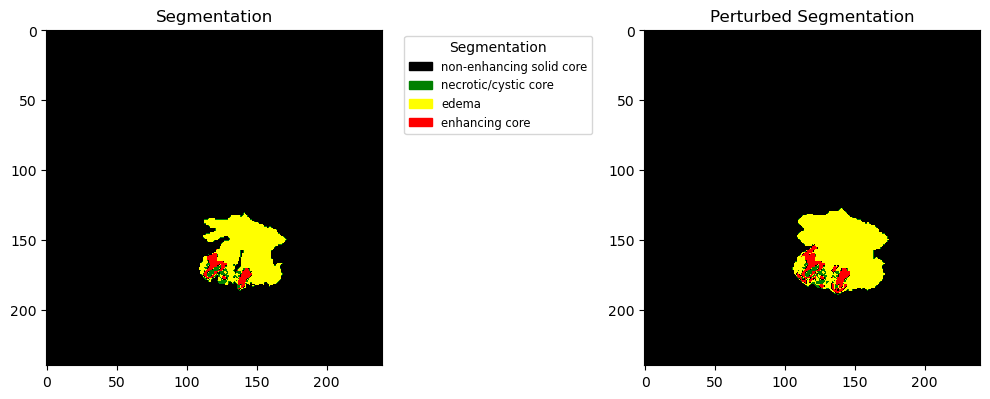

Patient ID: BraTS20_Training_018
Grade: HGG


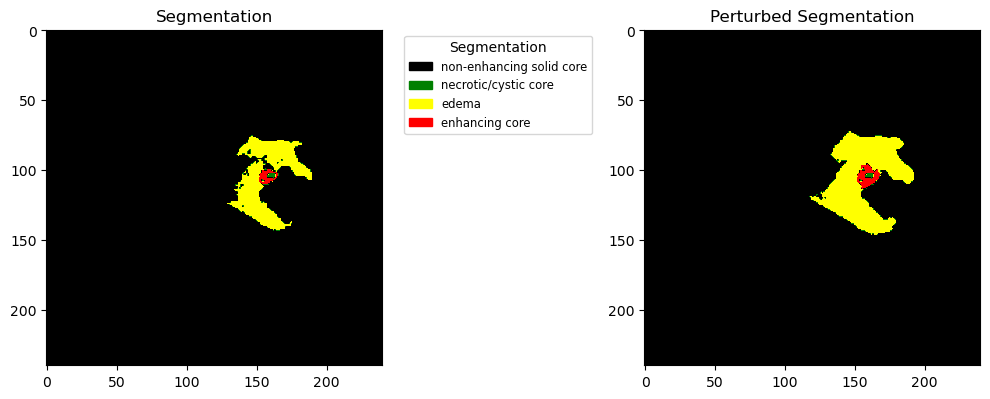

Patient ID: BraTS20_Training_019
Grade: HGG


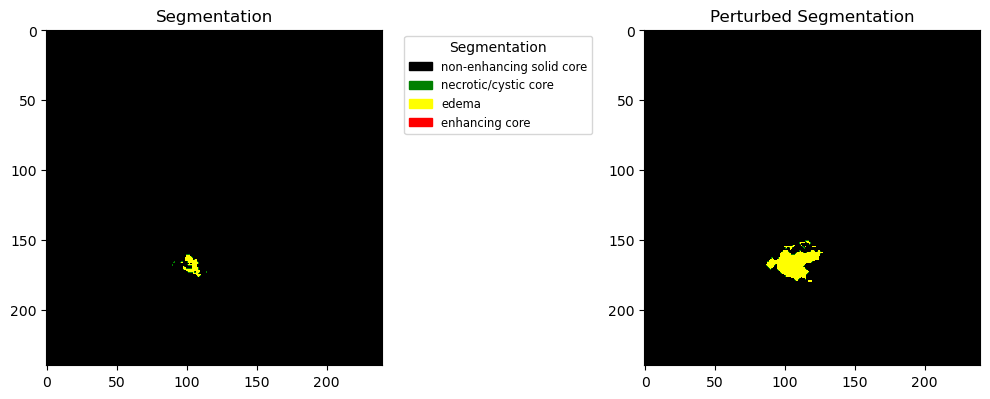

Patient ID: BraTS20_Training_020
Grade: HGG


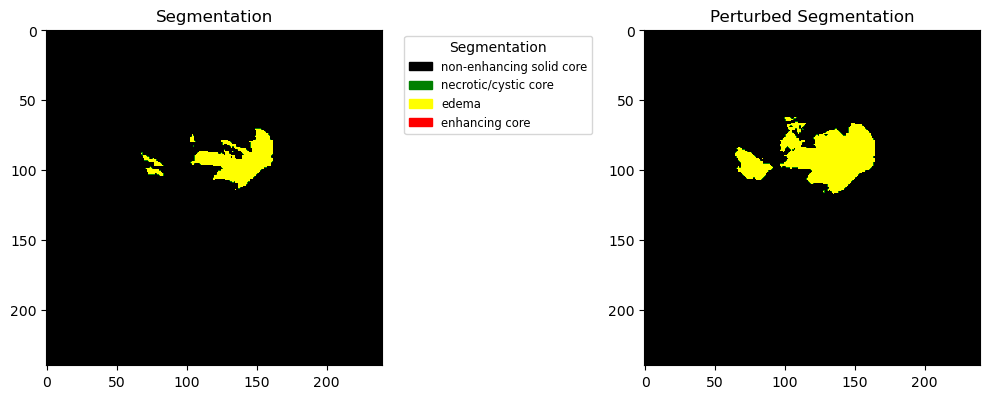

Patient ID: BraTS20_Training_021
Grade: HGG


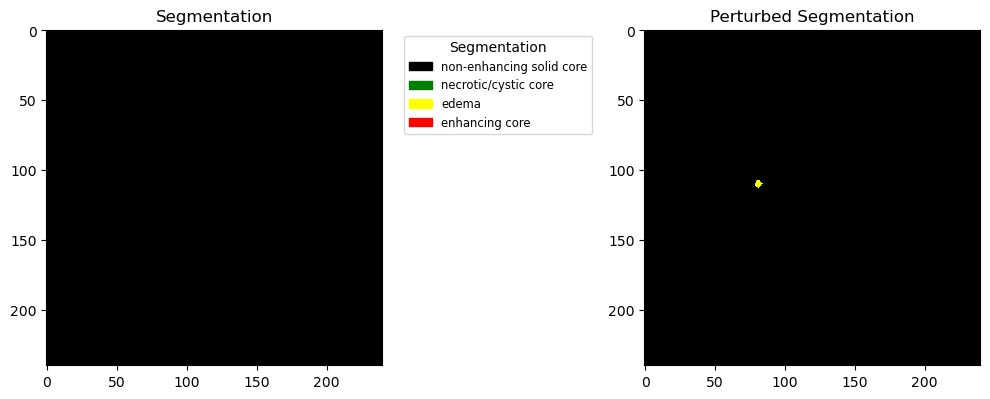

Patient ID: BraTS20_Training_022
Grade: HGG


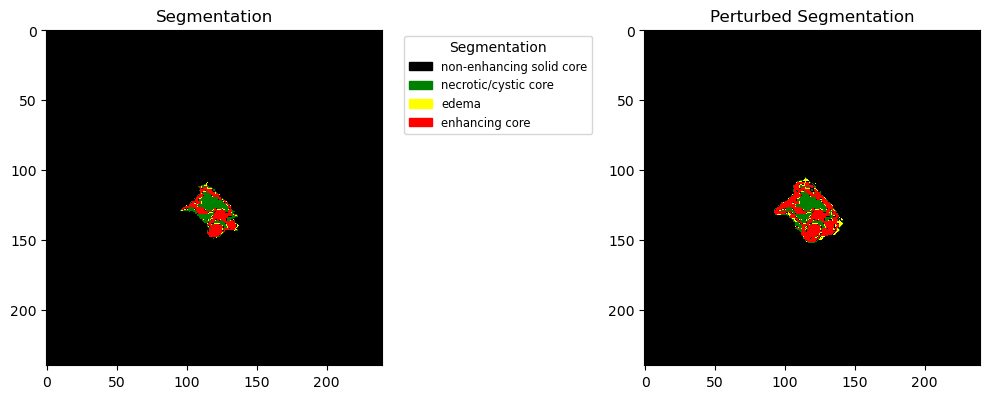

Patient ID: BraTS20_Training_023
Grade: HGG


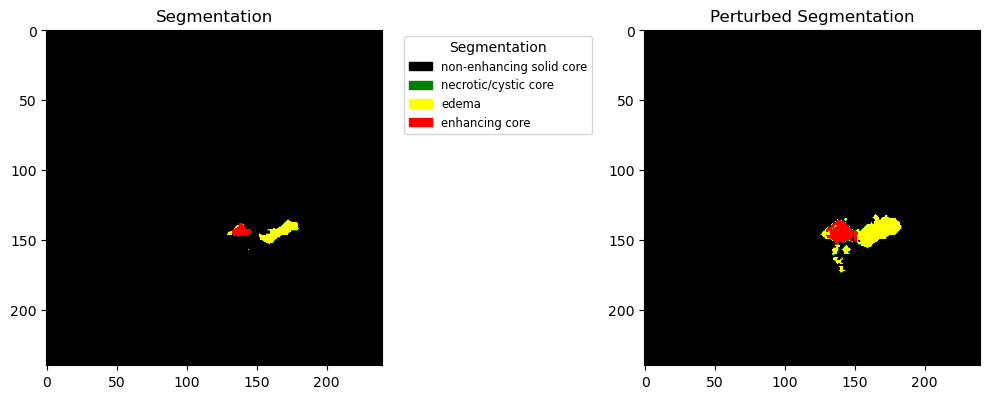

Patient ID: BraTS20_Training_024
Grade: HGG


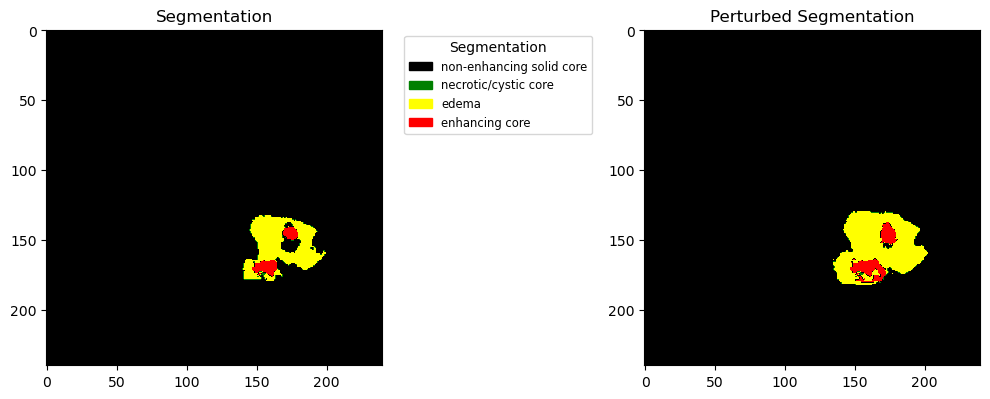

Patient ID: BraTS20_Training_025
Grade: HGG


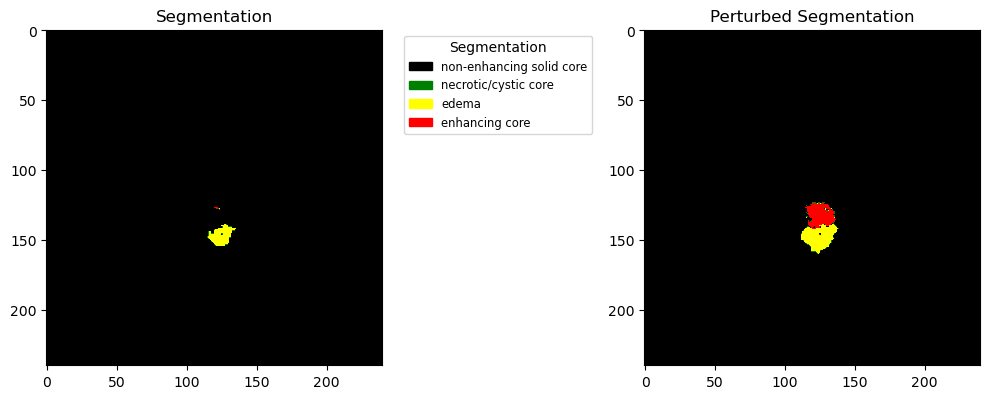

Patient ID: BraTS20_Training_026
Grade: HGG


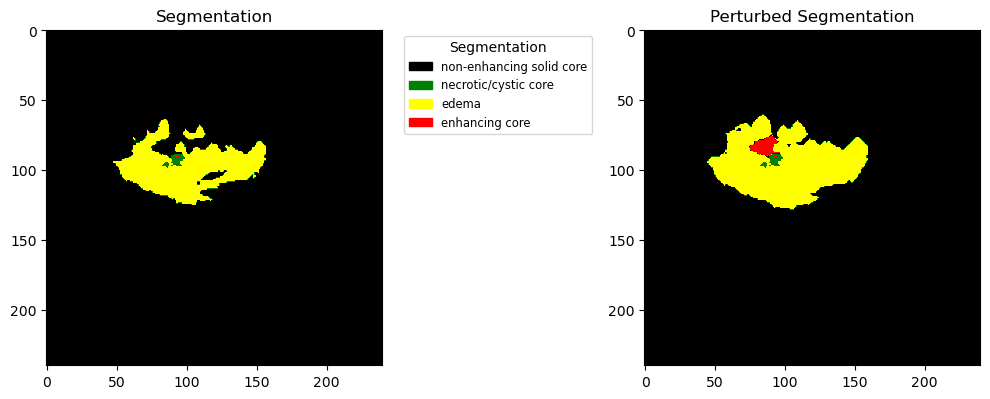

Patient ID: BraTS20_Training_027
Grade: HGG


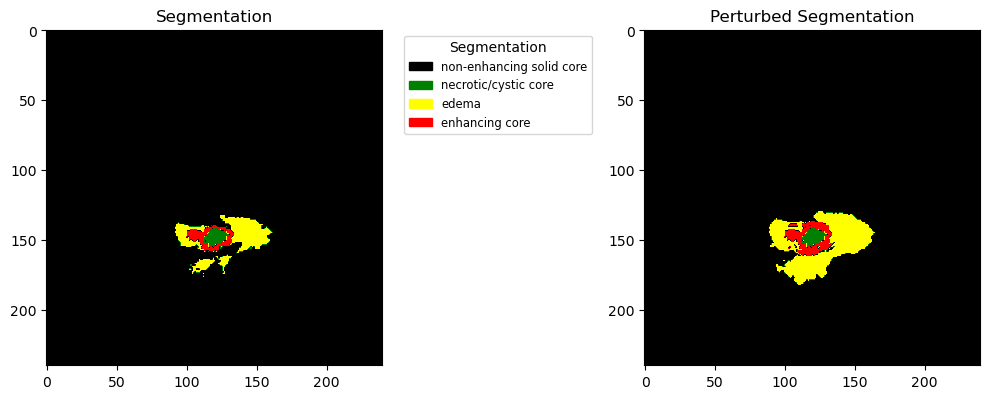

Patient ID: BraTS20_Training_028
Grade: HGG


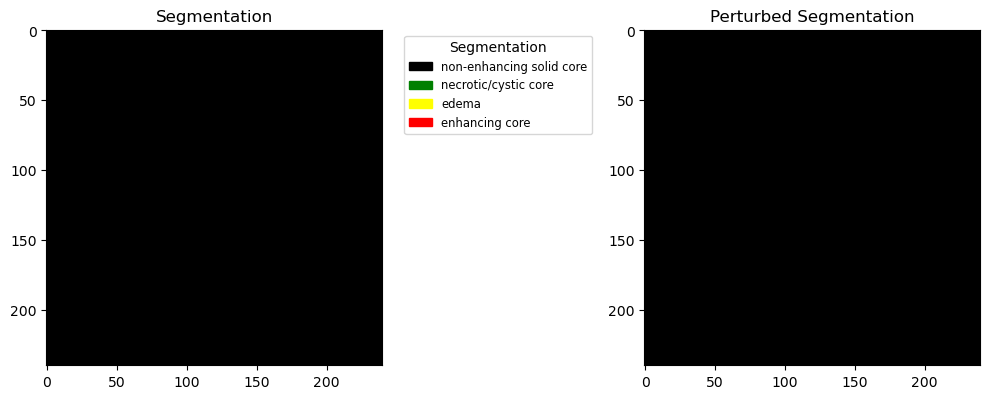

Patient ID: BraTS20_Training_029
Grade: HGG


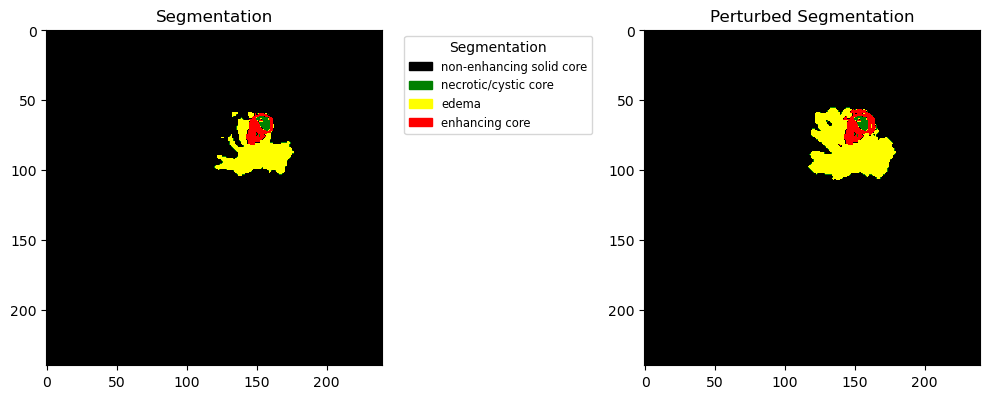

Patient ID: BraTS20_Training_030
Grade: HGG


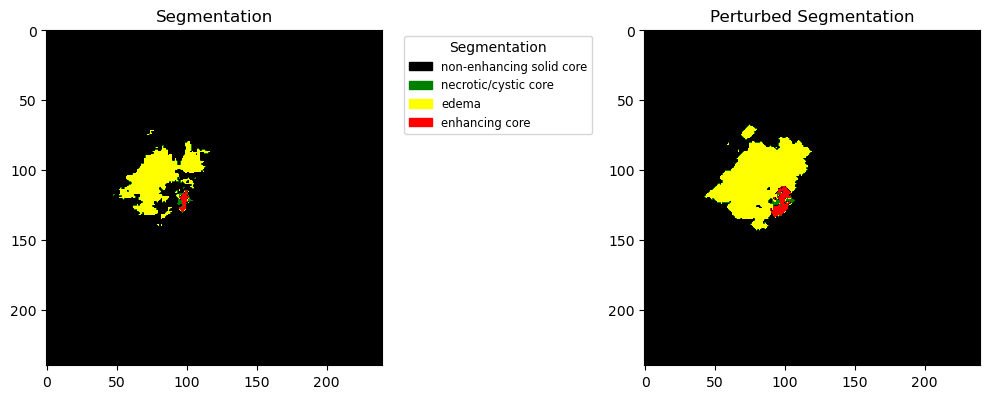

Patient ID: BraTS20_Training_031
Grade: HGG


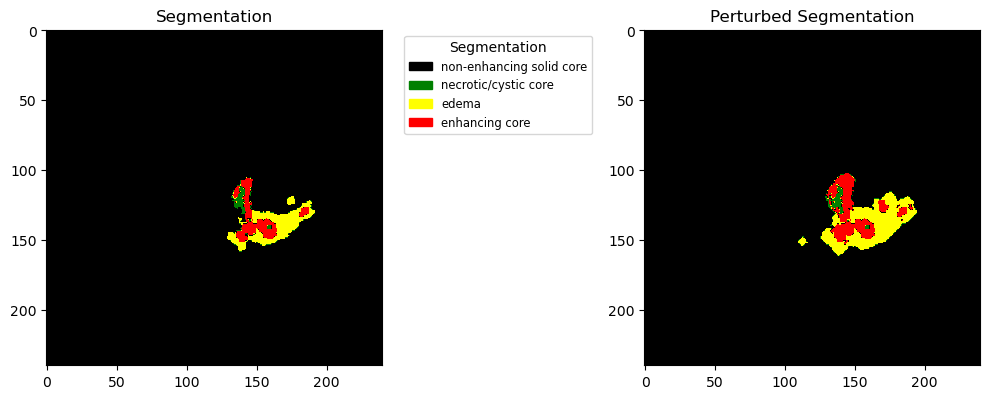

Patient ID: BraTS20_Training_272
Grade: LGG


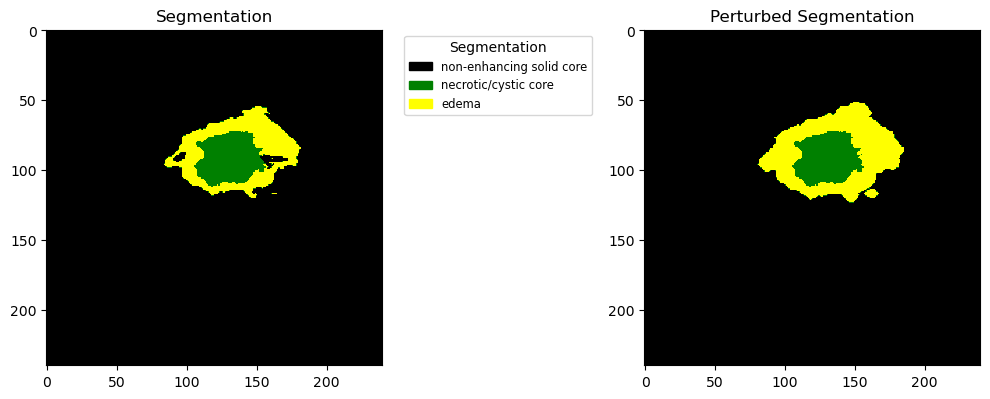

Patient ID: BraTS20_Training_273
Grade: LGG


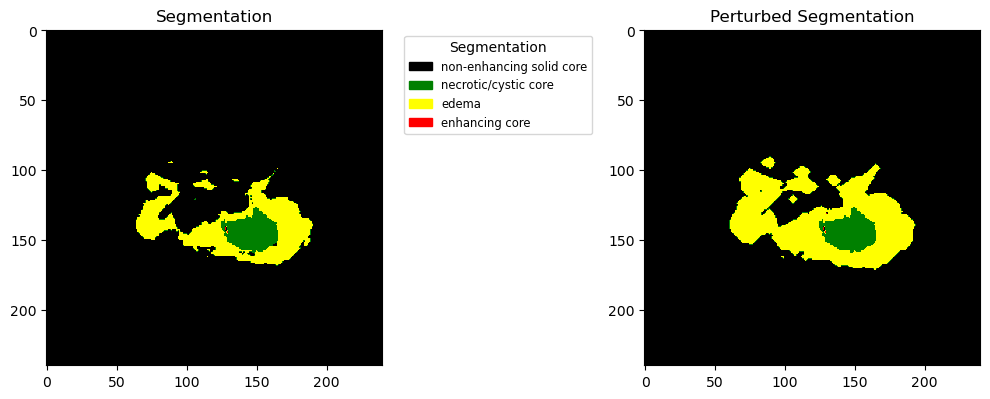

Patient ID: BraTS20_Training_274
Grade: LGG


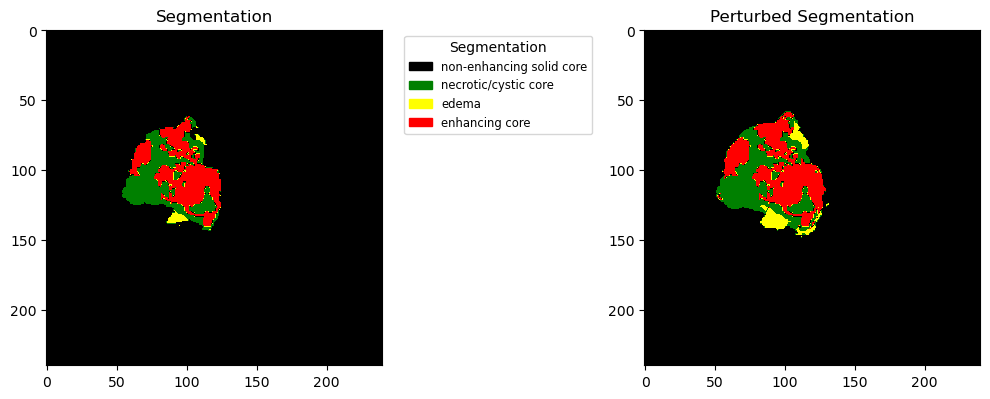

Patient ID: BraTS20_Training_275
Grade: LGG


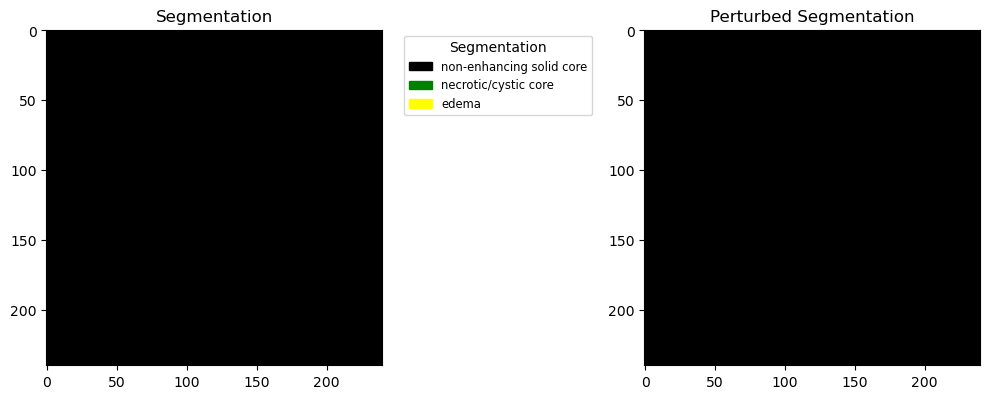

Patient ID: BraTS20_Training_276
Grade: LGG


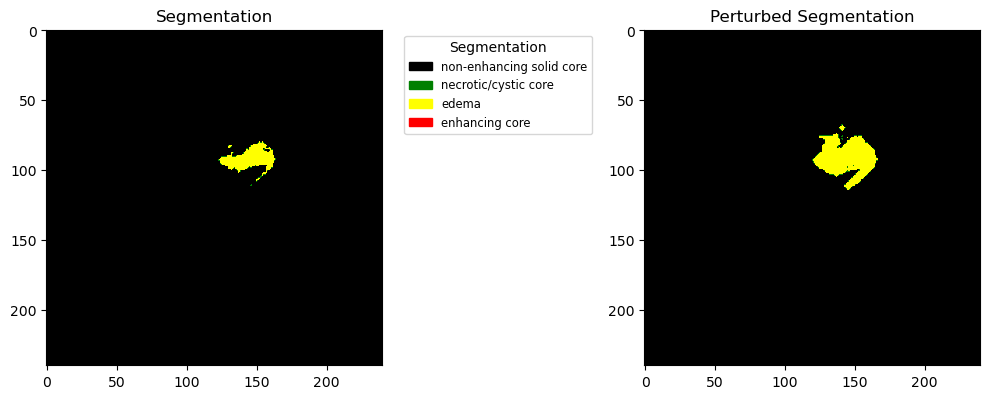

Patient ID: BraTS20_Training_277
Grade: LGG


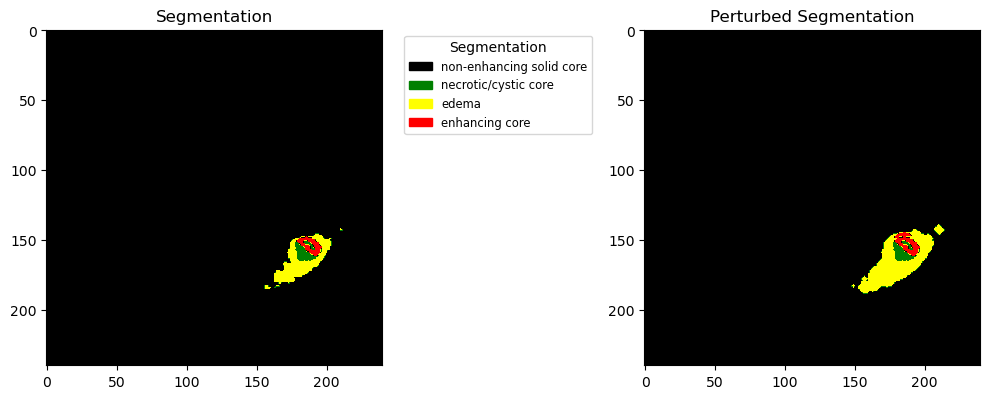

Patient ID: BraTS20_Training_278
Grade: LGG


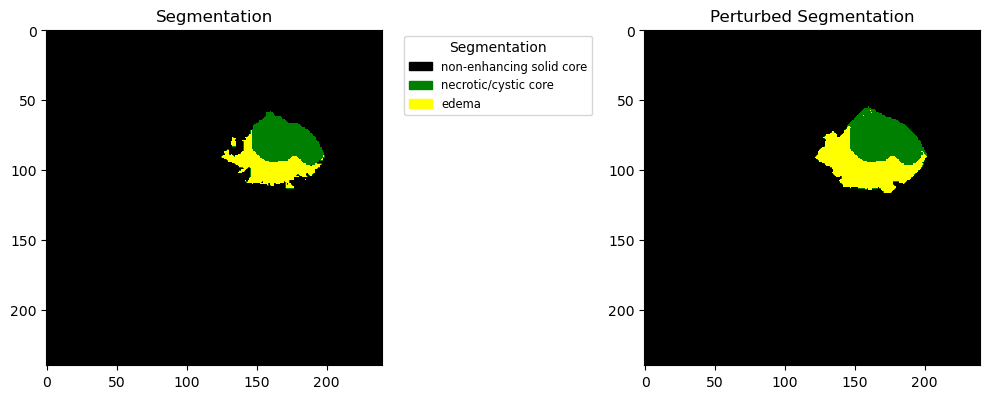

Patient ID: BraTS20_Training_279
Grade: LGG


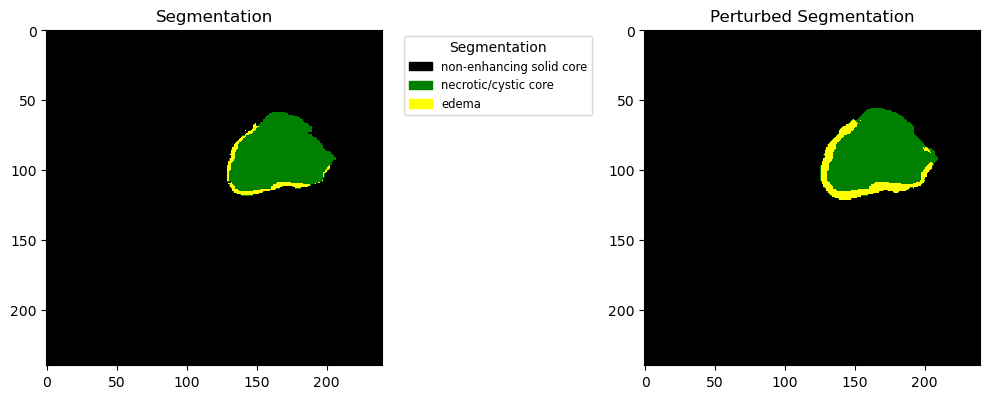

Patient ID: BraTS20_Training_280
Grade: LGG


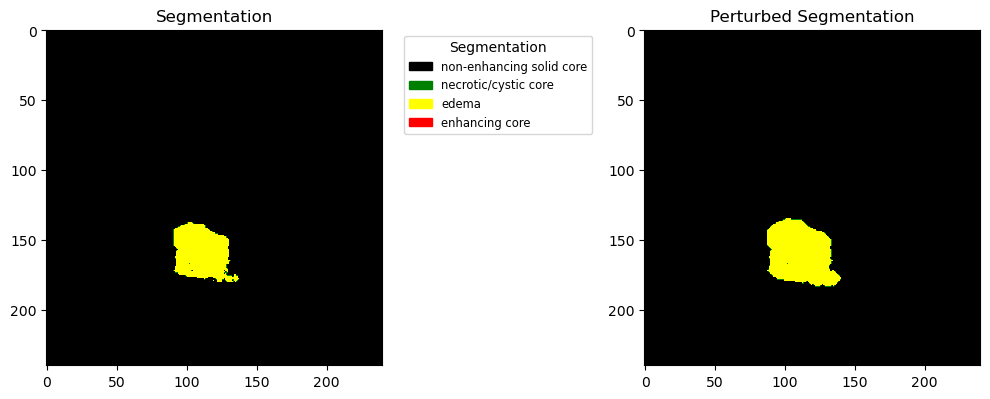

Patient ID: BraTS20_Training_281
Grade: LGG


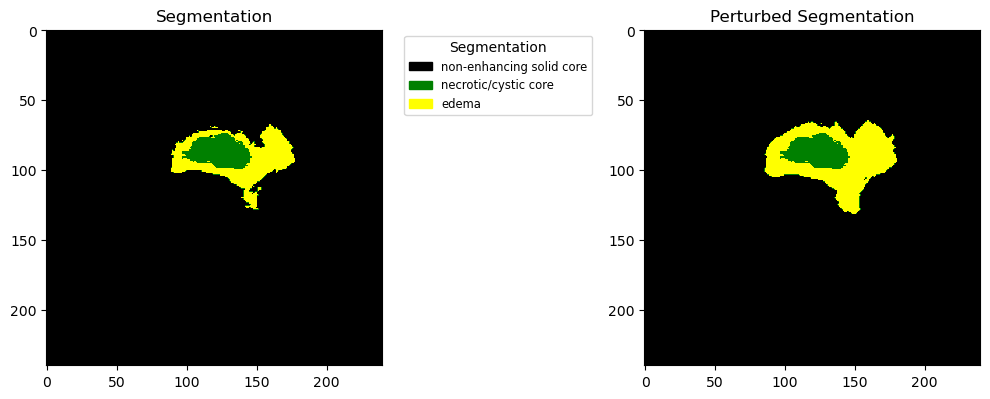

Patient ID: BraTS20_Training_282
Grade: LGG


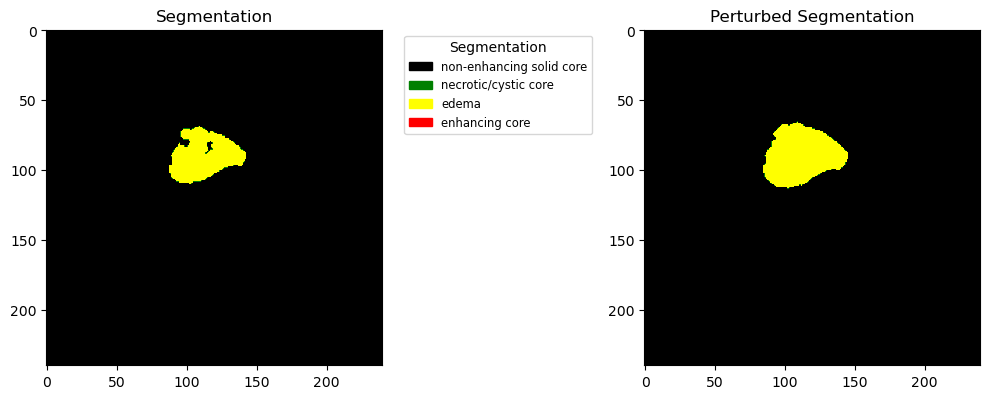

Patient ID: BraTS20_Training_283
Grade: LGG


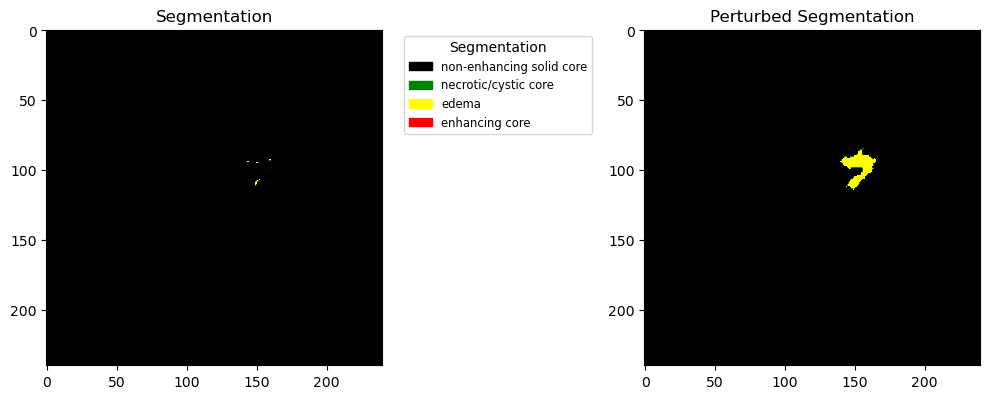

Patient ID: BraTS20_Training_284
Grade: LGG


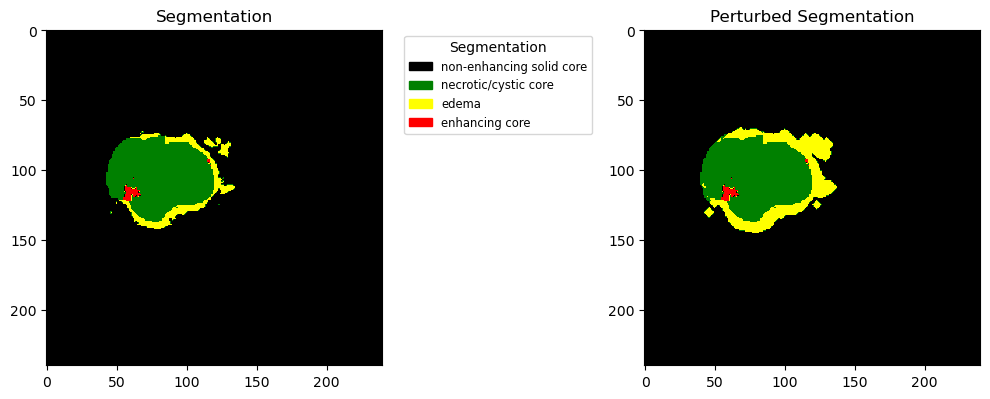

Patient ID: BraTS20_Training_285
Grade: LGG


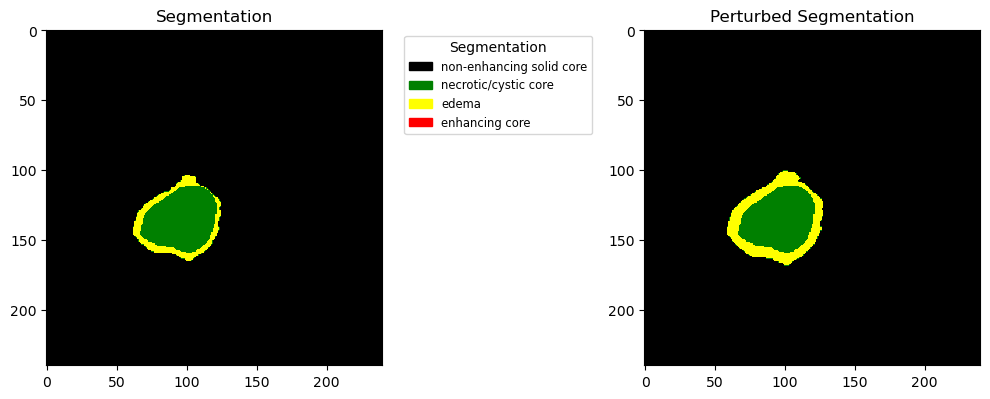

Patient ID: BraTS20_Training_286
Grade: LGG


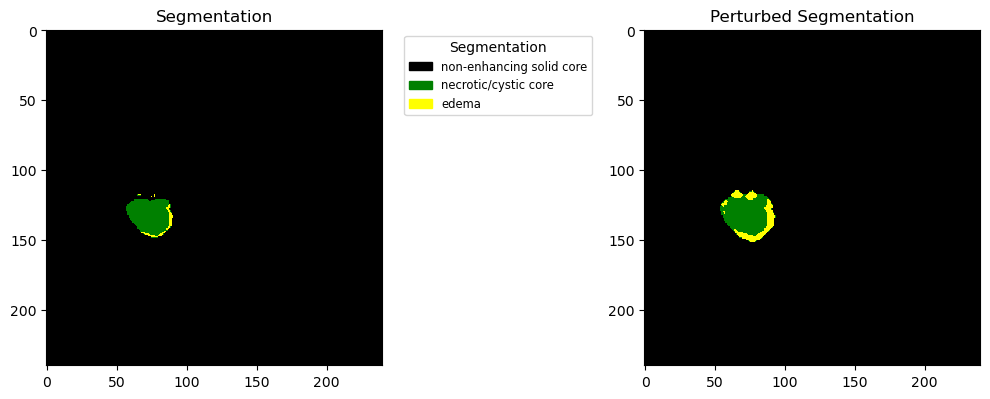

Patient ID: BraTS20_Training_287
Grade: LGG


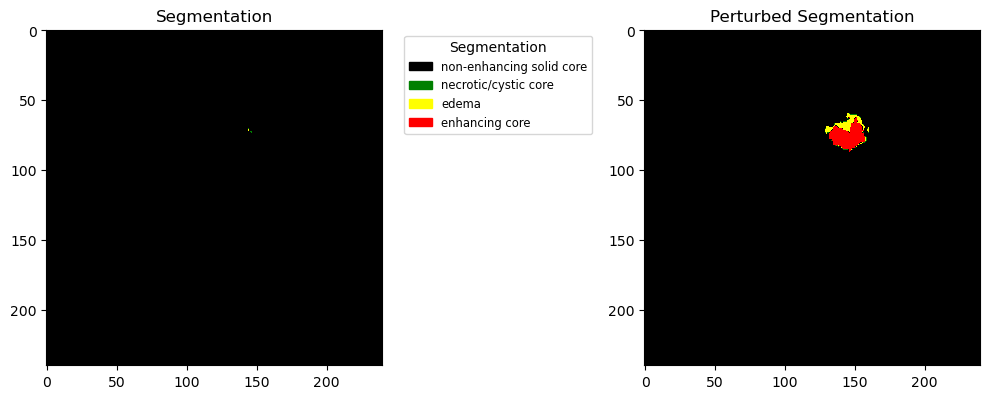

Patient ID: BraTS20_Training_288
Grade: LGG


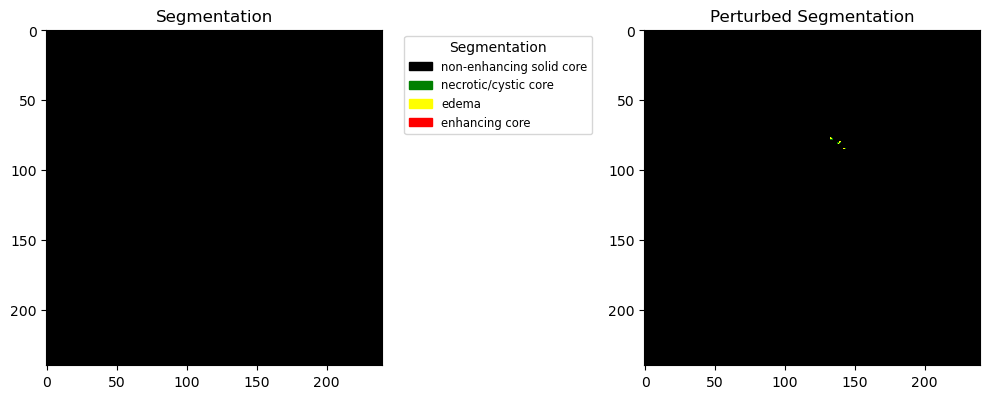

Patient ID: BraTS20_Training_289
Grade: LGG


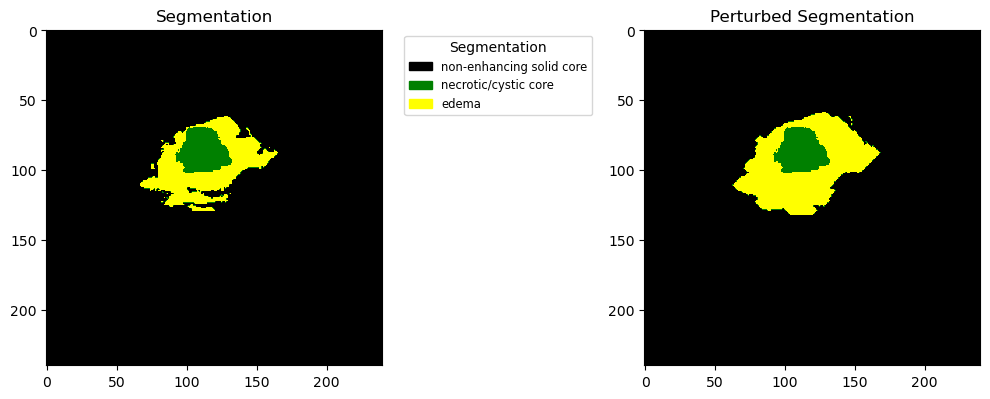

Patient ID: BraTS20_Training_290
Grade: LGG


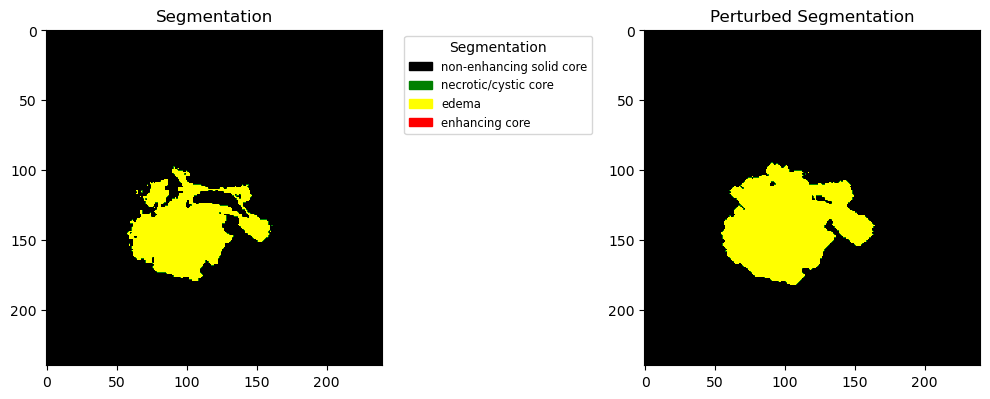

Patient ID: BraTS20_Training_291
Grade: LGG


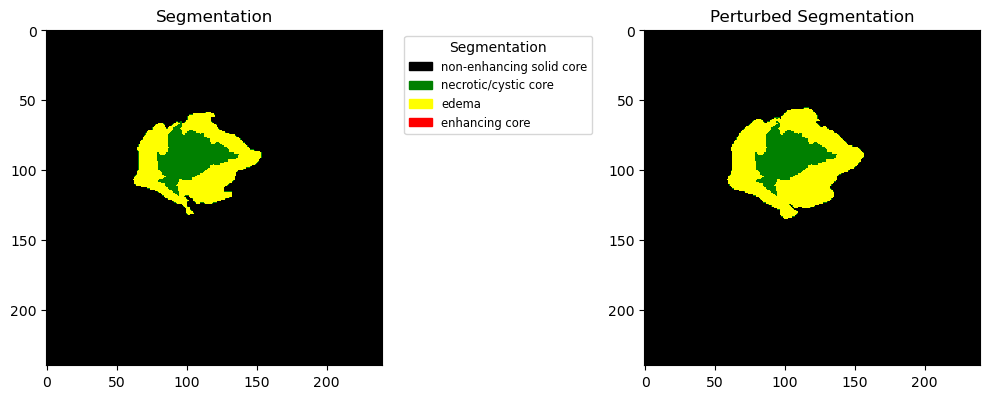

Patient ID: BraTS20_Training_292
Grade: LGG


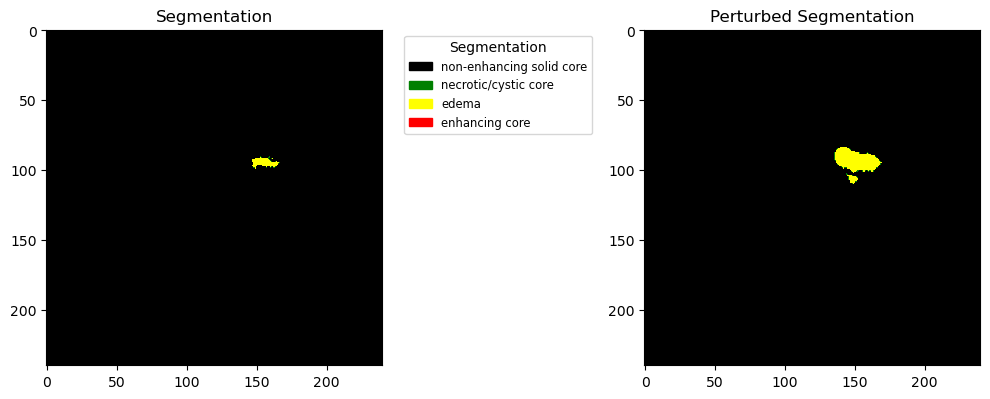

Patient ID: BraTS20_Training_293
Grade: LGG


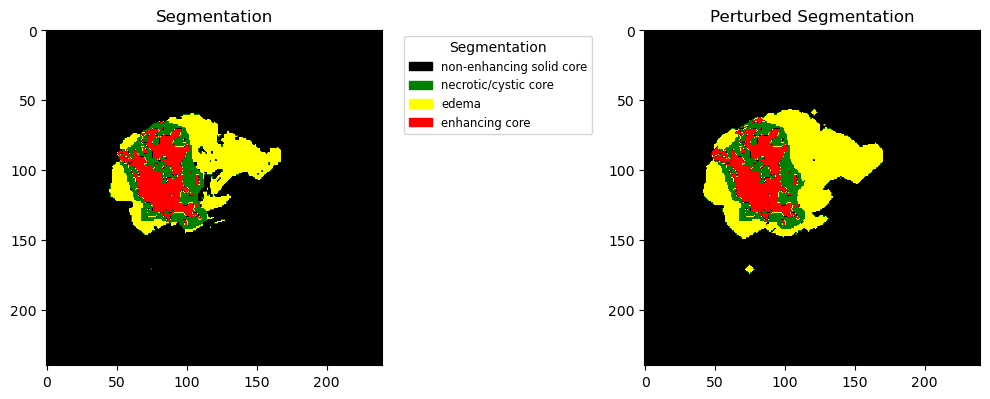

Patient ID: BraTS20_Training_294
Grade: LGG


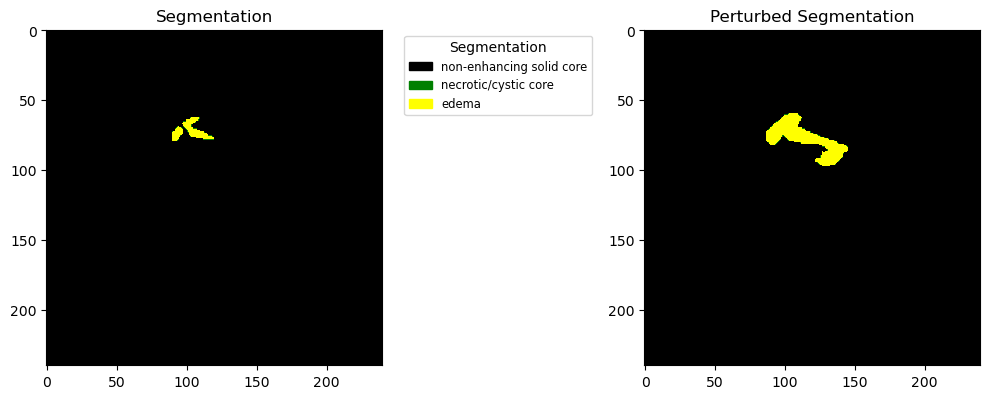

Patient ID: BraTS20_Training_295
Grade: LGG


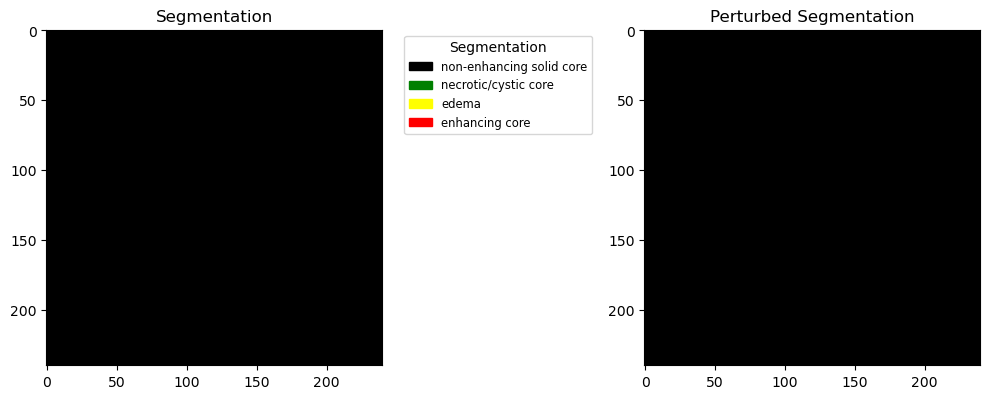

Patient ID: BraTS20_Training_296
Grade: LGG


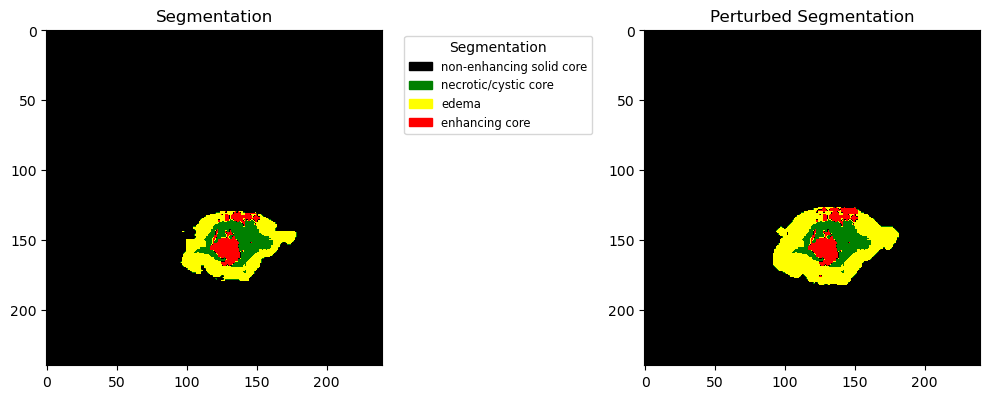

Patient ID: BraTS20_Training_297
Grade: LGG


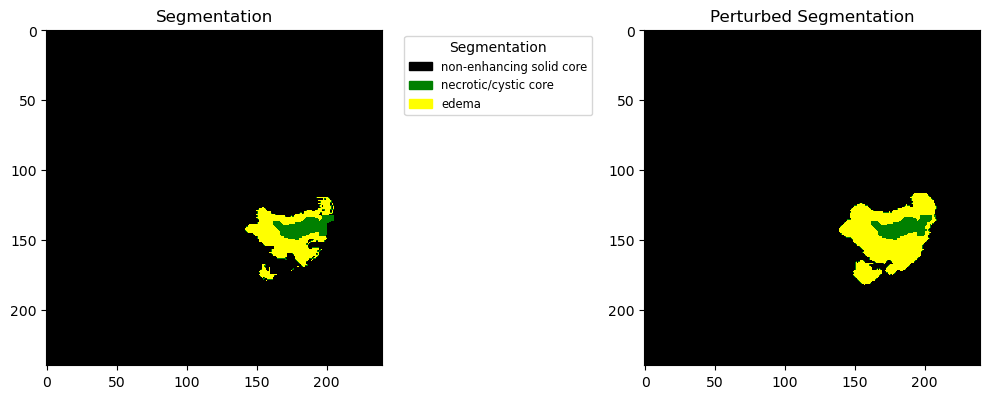

Patient ID: BraTS20_Training_298
Grade: LGG


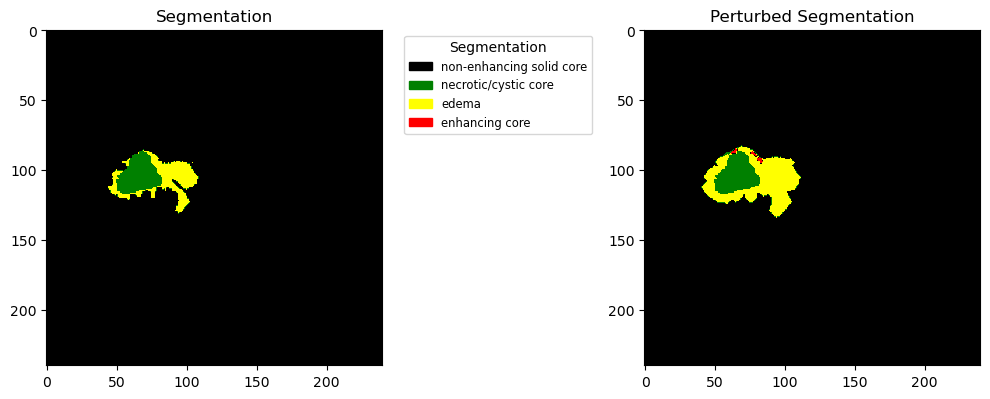

Patient ID: BraTS20_Training_299
Grade: LGG


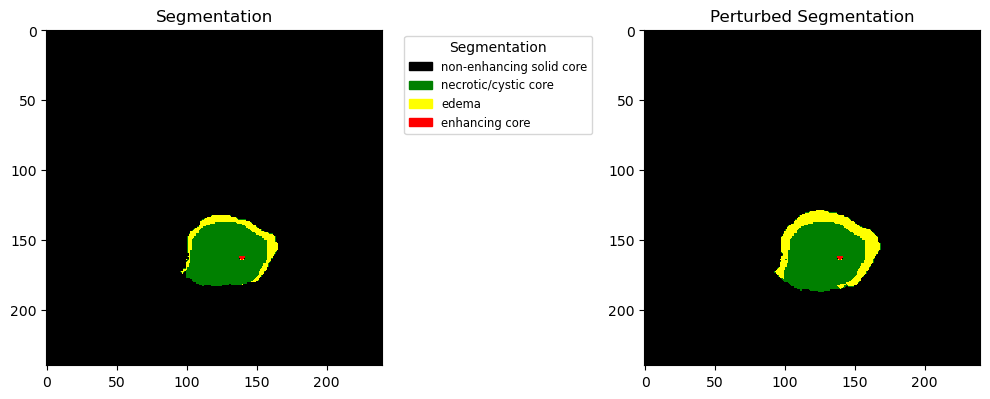

Patient ID: BraTS20_Training_300
Grade: LGG


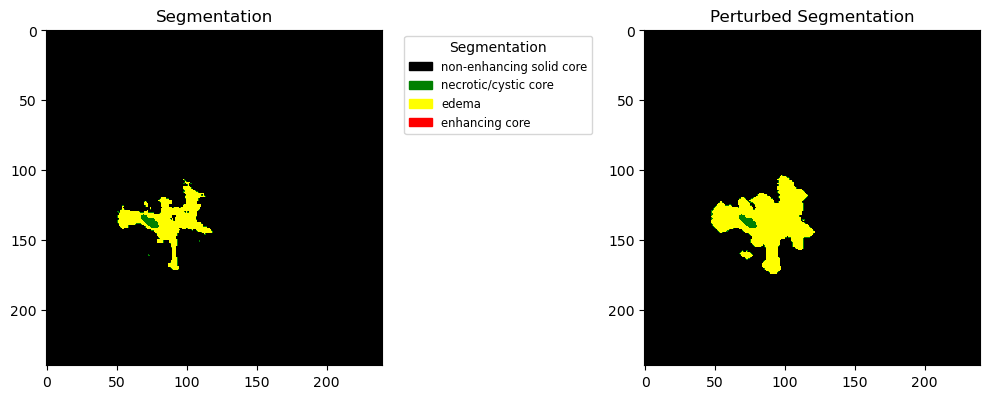

Patient ID: BraTS20_Training_301
Grade: LGG


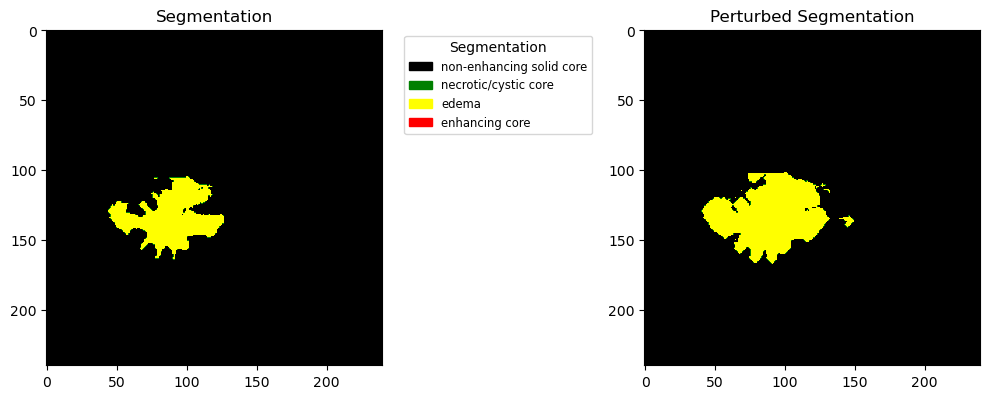

In [52]:
try: 
    for patient_id in patient_ids:
        print(f"Patient ID: {patient_id}")
        print(f"Grade: {map_train[map_train['BraTS_2020_subject_ID'] == patient_id]['Grade'].values[0]}")
        plot_segmentations(patient_id, path_train)
except Exception as e:
    print(f"Error plotting segmentations: {e}")


In [34]:
map_train = map_train[~map_train['BraTS_2020_subject_ID'].isin(faulty_ids)]